In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms, utils, models, datasets
from torch.utils.data import Dataset, DataLoader

In [4]:
from synthetic_utils import *

In [5]:
from trainer_dataloader import *
from networks import *
from losses import *

In [6]:
input_size = 96
batch_size = 64
num_workers = 4
num_epochs = 20

In [7]:
cuda = False
pin_memory = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    cuda = True
    cudnn.benchmark = True
    pin_memory = True
else:
    device = torch.device("cpu")

print('Device set: {}'.format(device))

Device set: cuda


In [8]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((input_size, input_size)),
#             transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'val': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
}

In [9]:
DATA_PATH = '../gen_shapes/'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'valid')
TEST_PATH = os.path.join(DATA_PATH, 'test')

In [10]:
train_df = datasets.ImageFolder(root=TRAIN_PATH, transform=data_transforms['train'])
val_df = datasets.ImageFolder(root=VAL_PATH, transform=data_transforms['val'])
test_df = datasets.ImageFolder(root=TEST_PATH, transform=data_transforms['val'])

In [11]:
train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

## LAFTR Training

In [ ]:
num_epochs = 1000

In [ ]:
from synthetic_dataloader import *
shapegender_train = ShapeGenderDataset(train_df)
shapegender_valid = ShapeGenderDataset(val_df)

In [ ]:
laftrtrain_loader = DataLoader(shapegender_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
laftrval_loader = DataLoader(shapegender_valid, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

In [ ]:
laftr_encoder = LeNet()
laftr_adversary = ClassNet()
laftr_classifier = ClassNet()

In [ ]:
# laftr_adv_criterion = AdvDemographicParityLoss()
laftr_adv_criterion = nn.BCELoss()
laftr_cls_criterion = nn.BCELoss()

In [17]:
laftr_opt_adv = optim.Adam(laftr_adversary.parameters(), lr=0.001, betas=(0.9, 0.999))
# laftr_opt_cls = optim.Adam(laftr_classifier.parameters(), lr=0.0001, betas=(0.9, 0.999))
# laftr_opt_enc = optim.Adam(laftr_encoder.parameters(), lr=0.0001, betas=(0.9, 0.999))

# laftr_opt_adv = optim.SGD(laftr_adversary.parameters(), lr=0.001, momentum=0.9)
laftr_opt_cls = optim.SGD(laftr_classifier.parameters(), lr=0.001, momentum=0.9)
laftr_opt_enc = optim.SGD(laftr_encoder.parameters(), lr=0.001, momentum=0.9)

laftr_scheduler_adv = lr_scheduler.StepLR(optimizer=laftr_opt_adv, gamma=0.99, step_size=1)
laftr_scheduler_cls = lr_scheduler.StepLR(optimizer=laftr_opt_cls, gamma=0.99, step_size=1)
laftr_scheduler_enc = lr_scheduler.StepLR(optimizer=laftr_opt_enc, gamma=0.99, step_size=1)

In [18]:
clsTrain_losses = []
clsTrain_accs = []
# trainCombined_losses = []
clsTrainCombined_losses = []
advTrain_losses = []
advTrain_accs = []
advTrainCombined_losses = []

combinedVal_losses = []
clsVal_losses = []
clsVal_accs = []
advVal_losses = []
advVal_accs = []

best_acc = 0.7
epoch_time = AverageMeter()


In [ ]:
ep_end = time.time()
for epoch in range(0, num_epochs):
#         print('-'*80)
        print('Epoch: {}/{}'.format(epoch, num_epochs))

        laftr_scheduler_adv.step()
        laftr_scheduler_cls.step()
        laftr_scheduler_enc.step()
        
        cls_loss, cls_en_acc, adv_loss, adv_acc, cls_en_combinedLoss, adv_combinedLoss = alfr_train(laftrtrain_loader,
                                                        laftr_encoder, laftr_classifier, laftr_adversary, laftr_opt_enc,
                                                        laftr_opt_cls, laftr_opt_adv, 
                                                        laftr_cls_criterion, laftr_adv_criterion, device)
        
        clsTrain_losses.append(cls_loss)
        clsTrain_accs.append(cls_en_acc)
        clsTrainCombined_losses.append(cls_en_combinedLoss)
        advTrain_losses.append(adv_loss)
        advTrain_accs.append(adv_acc)
#         trainCombined_losses.append(combined_loss)
        advTrainCombined_losses.append(adv_combinedLoss)
        
        print('\nClassifier accuracy: {}\t Adversary Accuracy: {}'.format(cls_en_acc, adv_acc))
        # validate
        print('-'*10)
        
        combinedVal_loss, clsVal_loss, clsVal_acc, advVal_loss, advVal_acc = laftr_validate_dp(laftrval_loader,
                                                        laftr_encoder, laftr_classifier, laftr_adversary, 
                                                        laftr_cls_criterion, laftr_adv_criterion, device)
        
        combinedVal_losses.append(combinedVal_loss)
        clsVal_losses.append(clsVal_loss)
        clsVal_accs.append(clsVal_acc)
        advVal_losses.append(advVal_loss)
        advVal_accs.append(advVal_acc)
        
        print('%'*20)
        print('Classifier validation acc: {:.4f} \t Adv validation acc: {:.4f}'.format(clsVal_acc, advVal_acc))
        
        if clsVal_acc > best_acc:
            best_acc = clsVal_acc
            torch.save(laftr_encoder, './weights/encoder_{}_{}.pth'.format(epoch, clsVal_acc))
            torch.save(laftr_classifier, './weights/cls_{}_{}.pth'.format(epoch, clsVal_acc))
            torch.save(laftr_adversary, './weights/adv_{}_{}.pth'.format(epoch, advVal_acc))

        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(431)
plt.title('Combined Val Loss')
# plt.plot(trainCombined_losses, label='Train')
plt.plot(combinedVal_losses, label='Validation')
plt.legend()

plt.subplot(432)
plt.title('Cls-Enc Loss')
plt.plot(clsTrain_losses, label='Train')
plt.plot(clsVal_losses, label='Validation')
plt.legend()

plt.subplot(433)
plt.title('Cls-Enc Accuracy')
plt.plot(clsTrain_accs, label='Train')
plt.plot(clsVal_accs, label='Validation')
plt.legend()

plt.subplot(434)
plt.title('Adv Loss')
plt.plot(advTrain_losses, label='Train')
plt.plot(advVal_losses, label='Validation')
plt.legend()

plt.subplot(435)
plt.title('Adv Accuracy')
plt.plot(advTrain_accs, label='Train')
plt.plot(advVal_accs, label='Validation')
plt.legend()

plt.subplot(436)
plt.title('Step Loss')
plt.plot(advTrainCombined_losses, label='Adversary')
plt.plot(clsTrainCombined_losses, label='Classifier')
plt.legend()

plt.tight_layout()

plt.savefig('./plots/laftr_train_{}{}.pdf'.format(time.localtime().tm_hour, time.localtime().tm_min))
pkl_path = './plots/metrics_{}{}.pkl'.format(time.localtime().tm_hour, time.localtime().tm_min)
with open(pkl_path, 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([advTrainCombined_losses, clsTrainCombined_losses, combinedVal_losses, clsTrain_losses,
                 clsVal_losses, clsTrain_accs, clsVal_accs, advTrain_losses, advVal_losses, advTrain_accs, advVal_accs], f)

In [12]:
laftr_encoder = torch.load('bce_indep_2/weights/encoder_258_0.736.pth')

In [13]:
from synthetic_dataloader import *
gender_train = GenderDataset(train_df)
gender_valid = GenderDataset(val_df)

In [14]:
advtrain_loader = DataLoader(gender_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
advval_loader = DataLoader(gender_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

In [15]:
adversary = ClassNet()

In [16]:
adv_criterion = nn.BCELoss()
# adv_criterion = AdvDemographicParityLoss()
opt_adv = optim.Adam(adversary.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_adv = lr_scheduler.StepLR(optimizer=opt_adv, gamma=0.99, step_size=1)

In [19]:
num_epochs = 100
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_adv.step()
        # train
        train_loss, train_acc = train_classifier_epoch(advtrain_loader, laftr_encoder,
                                adversary, opt_adv, adv_criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_classifier_epoch(advval_loader, laftr_encoder, adversary,
                                 adv_criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/100


/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/79]	Time 1.661 (1.661)	Loss 0.6265 (0.6265)	Accuracy 0.6250 (0.6250)
Batch: [10/79]	Time 0.067 (0.410)	Loss 0.6175 (0.5867)	Accuracy 0.6875 (0.7017)
Batch: [20/79]	Time 1.278 (0.406)	Loss 0.6191 (0.5866)	Accuracy 0.6562 (0.6972)
Batch: [30/79]	Time 0.033 (0.367)	Loss 0.5458 (0.5843)	Accuracy 0.7812 (0.6981)
Batch: [40/79]	Time 1.196 (0.376)	Loss 0.5540 (0.5850)	Accuracy 0.7344 (0.7016)
Batch: [50/79]	Time 0.057 (0.359)	Loss 0.5542 (0.5811)	Accuracy 0.7812 (0.7071)
Batch: [60/79]	Time 1.170 (0.365)	Loss 0.6172 (0.5839)	Accuracy 0.6719 (0.7041)
Batch: [70/79]	Time 0.040 (0.353)	Loss 0.4970 (0.5834)	Accuracy 0.8125 (0.7053)
----------


/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Avg validation loss: 0.5851135773658752 	 Accuracy: 0.704
--------------------
Epoch 0/100	Time 30.418 sec (30.418 sec)
--------------------
Epoch: 1/100


/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/79]	Time 1.766 (1.766)	Loss 0.6274 (0.6274)	Accuracy 0.5938 (0.5938)
Batch: [10/79]	Time 0.040 (0.432)	Loss 0.6457 (0.5886)	Accuracy 0.6094 (0.6960)
Batch: [20/79]	Time 1.195 (0.413)	Loss 0.6445 (0.5847)	Accuracy 0.5781 (0.7009)
Batch: [30/79]	Time 0.064 (0.371)	Loss 0.5432 (0.5846)	Accuracy 0.7500 (0.6951)
Batch: [40/79]	Time 1.318 (0.381)	Loss 0.6720 (0.5874)	Accuracy 0.5625 (0.6867)
Batch: [50/79]	Time 0.045 (0.361)	Loss 0.5165 (0.5883)	Accuracy 0.7344 (0.6829)
Batch: [60/79]	Time 1.235 (0.368)	Loss 0.6340 (0.5878)	Accuracy 0.6406 (0.6860)
Batch: [70/79]	Time 0.058 (0.356)	Loss 0.5319 (0.5842)	Accuracy 0.8125 (0.6967)
----------
Avg validation loss: 0.580982280254364 	 Accuracy: 0.718
--------------------
Epoch 1/100	Time 30.523 sec (30.471 sec)
--------------------
Epoch: 2/100
Batch: [0/79]	Time 1.833 (1.833)	Loss 0.5257 (0.5257)	Accuracy 0.7812 (0.7812)
Batch: [10/79]	Time 0.042 (0.422)	Loss 0.5917 (0.5633)	Accuracy 0.7031 (0.7344)
Batch: [20/79]	Time 1.178 (0.409)	Loss

Process Process-468:
Process Process-467:
Process Process-466:
Process Process-465:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/s1791387/miniconda3/envs/diss/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/s1791387/miniconda3/envs/diss/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/s1791387/miniconda3/envs/diss/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/s1791387/miniconda3/envs/diss/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/s1791387/miniconda3/envs/diss/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/s1791387/miniconda3/envs/diss/lib/python3.6/multiprocessing/process.py", line 258, in 

Traceback (most recent call last):
  File "/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-5d93558c7122>", line 13, in <module>
    adversary, opt_adv, adv_criterion, device)
  File "/mnt/mscteach_home/s1791387/diss/synthetic_expr/trainer_dataloader.py", line 495, in train_classifier_epoch
    for batch_idx, (imgs, labels) in enumerate(dataloader):
  File "/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 330, in __next__
    idx, batch = self._get_batch()
  File "/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 309, in _get_batch
    return self.data_queue.get()
  File "/home/s1791387/miniconda3/envs/diss/lib/python3.6/queue.py", line 164, in get
    self.not_empty.wait()
  File "/home/s1791387/miniconda3/envs/diss/lib/python3.6/t

KeyboardInterrupt: 

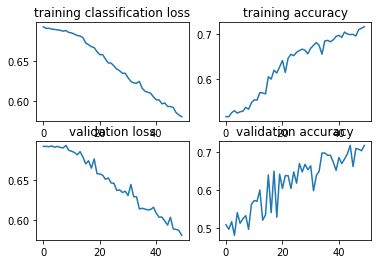

In [18]:
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)